# Instruction-Tuning Large Language Models (LLMs) with HuggingFace, LoRA and SFTTrainer

### Author

[Ufuk Birbiri](https://www.linkedin.com/in/ufuk-birbiri-84881b213/) is a Data Scientist and currently working at KARL STORZ (2025) in Germany. Follow me on LinkedIn.

Github: https://github.com/CemBirbiri

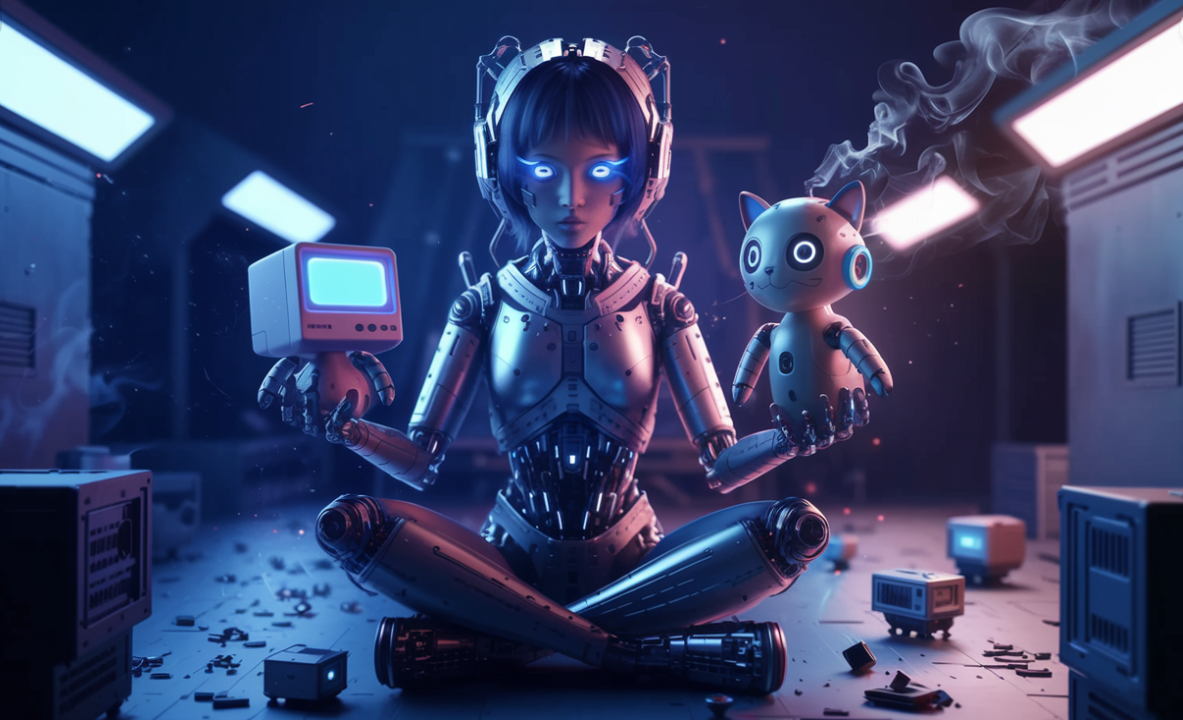

The above image is created using [ideogram.ai](https://ideogram.ai/t/explore)




Over the past few years, large language models (LLMs) have advanced considerably. Despite their growing capabilities, they often struggle to deliver accurate responses to user inquiries if not optimized well. A variety of methods - prompt engineering, fine-tuning, retrieval-augmented generation (RAG), and systematic prompting - have aimed to close this gap. In this article we will cover Instruction-tuning technique with a code example.

### Objectives:

- Gain familiarity with a range of template types - including instruction-response, question-answering, summarization, code generation, dialogue, data analysis, and explanation.
- Format datasets accordingly for effective model training.
- Implement instruction fine-tuning through Hugging Face libraries
- Utilize Low-Rank Adaptation (LoRA) for efficient LLM optimization.
- Configure and use the SFTTrainer for supervised fine-tuning.

What is Instruction Tuning ?
Instruction tuning (also called Instruction GPT) is a specialized fine-tuning approach where a model is trained on pairs of instructions and outputs, allowing it to learn how to perform specific tasks based on those instructions. With this method you don't have to train your LLM from scratch because you fine-tune a pretrained language model. Instruction tuning usually takes place before performing direct preference optimization (DPO) or reinforcement learning from human feedback (RLHF). We will not cover DPO and PLHF in this article.


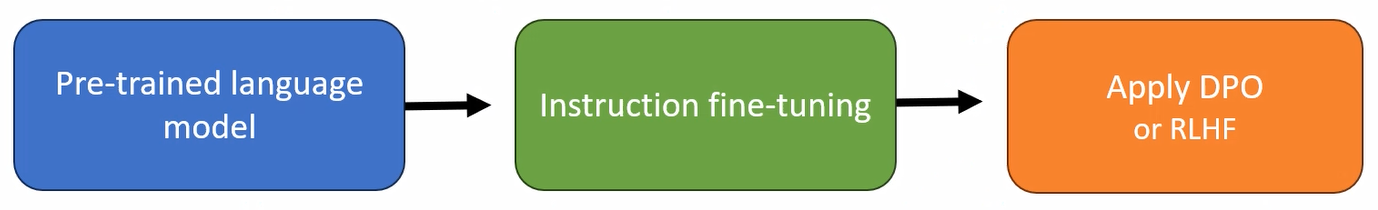

In instruction tuning, the dataset is crucial because it presents structured examples of instructions & responses. Let's see some data examples.

---
#### Instruction and output example:
Template: `### Instruction: {instruction}\n ### Output: {output}`

```
### Instruction: Translate the following sentence to German: "Hello, how are you?"
### Output: Hallo, wie geht's?
```
---

#### Code generation example:
Template: `### Task: {task_description}\n ### Code: {code_output}`

```
### Task: Write a function to multiplies two numbers in Python.
### Code: def add(a, b):\n    return a * b
```
---

#### Data Analysis example:
Template: `### Instruction: {instruction}\n ### Output: {output}`

```
### Instruction: Provide insights from the sales data of Q3 2024.
### Output: The sales decreased by 10% compared to Q2 2024, with the lowest growth in the beauty category.
```
---



Let's implement instruction tuning.


### Install

Install required libraries.

In [1]:
!pip install datasets
!pip install trl==0.9.6
!pip install transformers
!pip install peft
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn==
!pip install scikit-learn
!pip install sacrebleu
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Import libraries and define device (CPU or GPU).

In [1]:
import io
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import evaluate
import matplotlib.pyplot as plt
from urllib.request import urlopen
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from tqdm import tqdm
from trl import SFTConfig
from trl import SFTTrainer
from trl import DataCollatorForCompletionOnlyLM
from peft import get_peft_model, LoraConfig, TaskType
import pickle
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset Description

We will use the [CodeAlpaca 20k dataset](https://github.com/sahil280114/codealpaca?tab=readme-ov-file#data-release), a programming-focused data where the instructions asks to write codes. The CodeAlpaca dataset includes the following elements:

`instruction:` String type that describes the specific task for the model. There are 20,000 unique instructions.

`input:` String type that provides additional context for the task. For example, if the instruction is "Write a SQL query that selects all the columns in VBAK table" the input would be the SQL query itself. Approximately 40% of the examples include an input.

`output:` String type that contains the response.

In [2]:
# Load the data
dataset = load_dataset("sahil2801/CodeAlpaca-20k")
# Get only training part
dataset = dataset['train']


In [3]:
dataset[1000]

{'output': 's = "Hello world" \ns = s[::-1] \nprint(s)',
 'instruction': 'Reverse the string given in the input',
 'input': 'Hello world'}

We will only focus on data points that have no input to keep it simple and then shuffle.



In [4]:
# Take data points without "input" element
dataset = dataset.filter(lambda example: len(example["input"]) == 0)
# shuffle the data
dataset = dataset.shuffle(seed=31)

In [5]:
dataset

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 9764
})

Split the dataset as train & test.


In [6]:
# Split the dataset
dataset_split = dataset.train_test_split(test_size=0.2, seed=31)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

dataset_split

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 7811
    })
    test: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 1953
    })
})

In [7]:
# Optional: Use a subset of the data to fasten the training time.
# Since we use CPU, it is better to use a subset to save time.
test_dataset=test_dataset.select(range(1000))
train_dataset=train_dataset.select(range(1000))

### Define the model and tokenizer

We will use the open-source [`opt-350m`](https://huggingface.co/facebook/opt-350m) model from HuggingFace. You can find the explanation of the model [here](https://arxiv.org/abs/2205.01068) and the corresonding Github repository [here](https://github.com/facebookresearch/metaseq).

The model was initially trained using a causal language modeling (CLM) approach. It is part of the same family of decoder-only models as GPT-3. Consequently, its pretraining followed a self-supervised causal language modeling objective.

In [8]:
# Load the model
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')

tokenizer.eos_token

'</s>'

### Data preprocessing

Before testing the performance of the model, we need to preprocess the test data to generate the prompt. The create_prompt function takes a dataset as input. For each element in the dataset, it structures the instruction and output into a predefined template.

In [9]:
# Preprocess the data and create promts
def create_promt(dataset):
  output_texts_1 = []
  for i in range(len(dataset['instruction'])):
    # create output with response
    text_1 = (
          f"### Instruction:\n{dataset['instruction'][i]}"
          f"\n\n### Output:\n{dataset['output'][i]}</s>"
      )

    output_texts_1.append(text_1)

  return output_texts_1

def create_promt_empty_response(dataset):

  output_texts_2 = []
  for i in range(len(dataset['instruction'])):

    # create output without response
    text_2 = (
        f"### Instruction:\n{dataset['instruction'][i]}"
        f"\n\n### Output:\n"
    )

    output_texts_2.append(text_2)
  return output_texts_2

# tokenize the processed data
expected_outputs = []
instructions_with_responses = create_promt(test_dataset)
only_instructions = create_promt_empty_response(test_dataset)

for instruction_response, instruction in tqdm(zip(instructions_with_responses, only_instructions), total=len(instructions_with_responses)):

    tokenized_response = tokenizer(instruction_response, return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instruction, return_tensors="pt")

    # Extract the expected output by decoding the difference
    expected_output = tokenizer.decode(
        tokenized_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:],
        skip_special_tokens=True
    )

    expected_outputs.append(expected_output)


100%|██████████| 1000/1000 [00:00<00:00, 1499.45it/s]


In [26]:
expected_outputs[0]

'\ntimes2 () {\n  value=$1\n  echo "$value*2 = $(($value*2))"\n}'

Print the processed results

In [27]:
print('instructions\n' + only_instructions[0], '\n')
print(' instructions_with_responses\n' + instructions_with_responses[0], '\n')
print('expected_outputs' + expected_outputs[0])

instructions
### Instruction:
Define a Bash function with name 'times2' which takes one parameter and prints the value doubled.

### Output:
 

 instructions_with_responses
### Instruction:
Define a Bash function with name 'times2' which takes one parameter and prints the value doubled.

### Output:
times2 () {
  value=$1
  echo "$value*2 = $(($value*2))"
}</s> 

expected_outputs
times2 () {
  value=$1
  echo "$value*2 = $(($value*2))"
}


It's advantageous to transform into a torch ListDataset. The code below introduces a class named ListDataset, which converts a list into a torch-compatible dataset.

In [11]:
# Define the ListDataset object
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(only_instructions)

### Implement instruction fine-tuning with LoRA

Fine-tuning the model for all the parameters could be time consuming and waste of resources. To optimize time, we'll use a parameter-efficient fine-tuning (PEFT) approach called [Low-Rank Adaptation (LoRA)](https://huggingface.co/docs/diffusers/en/training/lora) for instruction fine-tuning. First, transform the model into a PEFT-compatible version for LoRA by defining a LoraConfig object from the peft library, specifying parameters such as the LoRA rank and target modules. Then, apply the LoRA configuration to the model using `get_peft_model()`, which effectively converts it into a LoRA model.

In [12]:
# Define LoRA parameters

#Parameters:
#r: low-rank dimension
#lora_alpha: scaling factor of LoRa
#target_modules: Modules to apply LoRA
#lora_dropout: Dropout rate
#task_type: #task type which is causal language model

lora_model_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    task_type=TaskType.CAUSAL_LM
)

# convert our model into a lora model
model = get_peft_model(model, lora_model_config)

Next we need to mask the generated responses, because we will be using the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) which outputs the instructions and the responses together. To evaluate the quality of the generated output, we can only consider the response text and not instruction. Therefore, we will mask the instruction part of the output text and only keep the response part of the output. We will use the `DataCollatorForCompletionOnlyLM` class from `trl` library.

In [13]:
# Define response template
response_template = "### Output:\n"
# Define function that masks
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

Using the masking in `DataCollatorForCompletionOnlyLM` we can exclude the instruction part from the loss calculation.

### Training

For the training we first define the `SFTConfig`, and then define the `SFTTrainer` object. The `SFTConfig` creates the parameters of the `SFTTrainer` such as number of epochs, batch size, max sequence length, etc.

In [14]:
# Define configuration and training parameters
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=3,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    max_seq_length=1024,
    do_eval=True
)

# Define SFTTrainer object
trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=create_promt,
    args=training_args,
    packing=False,
    data_collator=collator,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Start training, save the training history to save the loss, and lastly save the model for later usage. PS: The training can be too long if you use CPU.

Note: To train the model you should open a free account at [Weights & Biases: The AI Developer Platform (wandb.ai)](https://wandb.ai/home) and get a free key.

In [15]:
# Start training
trainer.train()
# Save the history
log_history_lora = trainer.state.log_history
# Save the model
trainer.save_model("./final_model_instruction_tuning_with_lora")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: uccbirbiri (uccbirbiri-karl-storz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.896100
1000,1.785100
1500,1.736800


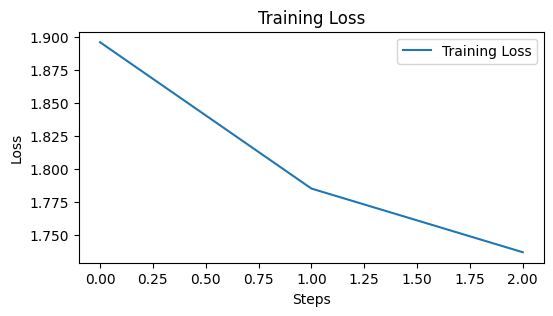

In [16]:
train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

# Plot the training loss
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

After training we define the text generation pipeline to test the model performance.

In [17]:
# Define the text generation pipeline
generation_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'Jamba

### Generate responses for the test data

Now we can generate the responses using the generation_pipeline which generates tokens trained model. Note that it takes so much time to generate responses if you use CPU.

In [20]:
# generate responses
# For the simplicity we will only generate 10 responses (since it is a Colab notebook and there is no GPU)
with torch.no_grad():
    pipeline_iterator= generation_pipeline(instructions_torch[:10],
                                #max length of responses
                                max_length=50,
                                num_beams=5,
                                early_stopping=True,)
# Save the generated outputs
generated_outputs = []
for text in pipeline_iterator:
    generated_outputs.append(text[0]["generated_text"])

In [29]:
print(generated_outputs[0])

def times2(x, y):
         


Print example response.

In [31]:
print(only_instructions[0], '\n')
print(expected_outputs[0], '\n')
print(generated_outputs[0], '\n')

### Instruction:
Define a Bash function with name 'times2' which takes one parameter and prints the value doubled.

### Output:
 


times2 () {
  value=$1
  echo "$value*2 = $(($value*2))"
} 

def times2(x, y):
          



### Test the performance with Blue Score

We can evaluate the alignments between the model's generated responses and the expected responses using BLEU score, a metric originally designed to assess the quality of machine translation outputs. BLEU calculates a similarity score by comparing each generated segment with a set of reference outputs, and the overall score is obtained by averaging these individual comparisons. Depending on the implementation, BLEU scores range either bettwen [0,1] or between [0,100]. Higher values indicate a stronger match between the generated and expected outputs.

BLEU scores may be a difficult evaluation method due to various implementation parameters. To address this, we use [SacreBLEU](https://huggingface.co/spaces/evaluate-metric/sacrebleu), a standardized variant of BLEU that ensures consistency across different evaluations.

In [35]:
import evaluate
import sacrebleu

# Load the Sacreblue metric
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs,
                                 references=expected_outputs[:10])

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.0


You can see that the fine-tuned model achieves a SacreBLEU score of 0.0. The reason why the score is too low is that we trained the model for 3 epochs only since we did run it on CPU. Therefore, the model couldn't learn and generalize well. You can use the code above to implement the instruct tuning method on LLMs.

---
